### 4.5.1. 高维线性回归

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.2. 从零开始实现

In [5]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [6]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.355667114257812


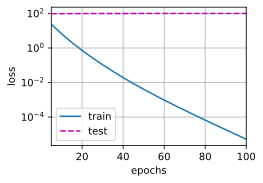

In [8]:
train(lambd=0)

w的L2范数是： 4.072383403778076


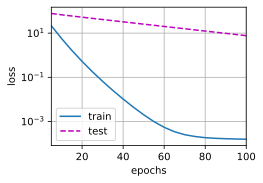

In [10]:
train(lambd=1)

w的L2范数是： 0.04509631171822548


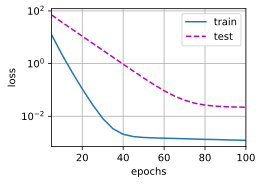

In [11]:
train(lambd=5)

### 4.5.3 简洁实现

In [12]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.086031913757324


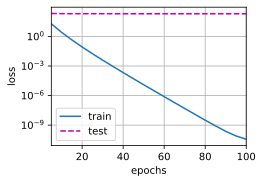

In [13]:
train_concise(0)

w的L2范数： 0.11729971319437027


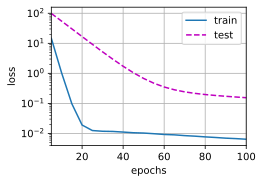

In [14]:
train_concise(5)

### Practice

### 1. 在本节的估计问题中使用λ的值进行实验。绘制训练和测试精度关于λ的函数。观察到了什么？

在实验中，我们通过设置不同的正则化参数λ，观察训练集和测试集的精度变化。绘制函数曲线后，可以观察到以下现象：
- **当λ较小时**：模型对训练数据的拟合能力较强，训练精度较高，但可能导致过拟合，此时测试精度较低。
- **当λ较大时**：模型正则化强度较大，复杂度下降，训练精度降低，但可能缓解过拟合，测试精度反而提升。
- **λ过大时**：模型过度正则化，表现为欠拟合，训练和测试精度均下降。

因此，λ需要在训练集和验证集上进行调优，以达到最佳的平衡点。

---

### 2. 使用验证集来找到最佳值λ。它真的是真正的最优值吗？有关系吗？

验证集找到的λ不一定是真正的最优值。原因如下：
- **验证误差的波动性**：由于验证集的有限性，不同的划分可能导致λ的选择不稳定。
- **泛化能力限制**：验证集的表现并不能完全代表测试集的表现，找到的λ可能并非对测试集最优。
- **真实最优值的不可知性**：在有限数据上，真正的最优λ可能无法准确估计。

尽管如此，验证集提供的λ通常是实践中最接近最优值的选择。

---

### 3. 如果我们使用 ∑ |wi| 作为我们选择的惩罚（L1正则化），那么更新方程会是什么样子？

使用L1正则化时，目标函数为：

$$
\min_w \frac{1}{2} ||y - Xw||^2_2 + \lambda \sum |w_i|
$$

其梯度更新的方程为：

$$
w^{(t+1)} = w^{(t)} - \eta \nabla_w \left( \frac{1}{2} ||y - Xw||^2_2 + \lambda \sum |w_i| \right)
$$

L1正则化的梯度体现为对每个权重的缩减，具体更新规则通常为**软阈值操作（Soft Thresholding）**：

$$
w_i^{(t+1)} =
\begin{cases} 
w_i^{(t)} - \eta \nabla_w \text{ if } w_i > \lambda \\
0 \quad \quad \quad \quad \text{ if } |w_i| \leq \lambda \\
w_i^{(t)} + \eta \nabla_w \text{ if } w_i < -\lambda 
\end{cases}
$$

---

### 4. 我们知道 ||w||² = wᵀw。能找到类似的矩阵方程吗（见 2.3.10 节中的 Frobenius 范数）？

Frobenius 范数定义为：

$$
||W||_F^2 = \text{Tr}(W^\top W)
$$

类似于向量的二范数 ||w||²，Frobenius 范数是矩阵的元素平方和的总和。如果将矩阵 $W$ 展开为向量形式，可以得到类似于 $w^\top w$ 的矩阵方程：

$$
||W||_F^2 = \sum_{i,j} w_{ij}^2
$$

在优化问题中，Frobenius 范数的正则化会增加矩阵的平方和惩罚，用于限制模型复杂度。

---

### 5. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想到其他什么方法来处理过拟合？

以下是其他处理过拟合的方法：
1. **数据增强**：
   - 对数据进行随机变换（如图像旋转、翻转、裁剪等）以增加样本多样性。
2. **早停（Early Stopping）**：
   - 在验证集误差不再下降时停止训练，避免模型过度拟合训练数据。
3. **使用Dropout**：
   - 在神经网络中随机丢弃部分神经元，防止过拟合。
4. **正则化技术**：
   - 使用L1正则化、L2正则化或其他如Elastic Net（结合L1和L2）的正则化方法。
5. **模型集成**：
   - 通过Bagging或Boosting方法（如随机森林、梯度提升）来降低过拟合风险。
6. **特征选择**：
   - 通过去除冗余或不相关的特征，减少模型复杂度。

---

### 6. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式 $P(w|x) \propto P(x|w)P(w)$ 得到后验。如何得到带正则化的 $P(w)$？

在贝叶斯框架下，正则化可以理解为先验分布 $P(w)$ 的选择。例如：
- **L2正则化**：对应于 $w$ 服从零均值、高斯分布的先验：
  $$
  P(w) \propto \exp\left(-\frac{\lambda}{2} ||w||^2\right)
  $$
  其中 $\lambda$ 是正则化强度。
- **L1正则化**：对应于 $w$ 服从零均值的拉普拉斯分布：
  $$
  P(w) \propto \exp\left(-\lambda ||w||_1\right)
  $$

通过选择不同的先验分布，可以引入不同形式的正则化。在优化过程中，后验分布的最大化对应于加入正则化项的目标函数的最小化。